In [1]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import random
import plotly.express as px

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
%matplotlib inline

In this notebook we calculate `Percent Replicating` to measure of the proportion of perturbations with detectable signature.

In [2]:
n_samples = 1000
n_replicates = 4

corr_replicating_df = pd.DataFrame()
group_by_feature = 'Metadata_broad_sample'

experiment = {
    'ORF':{'A549':{'48':{'BR00117020':'A549 48-hour ORF Plate 1',
                         'BR00117021':'A549 48-hour ORF Plate 2'
                         },
                   '96':{'BR00118050':'A549 96-hour ORF Plate 1',
                         'BR00117006':'A549 96-hour ORF Plate 2'
                         }
                   },
           'U2OS':{'48':{'BR00117022':'U2OS 48-hour ORF Plate 1',
                         'BR00117023':'U2OS 48-hour ORF Plate 2'
                         },
                   '96':{'BR00118039':'U2OS 96-hour ORF Plate 1',
                         'BR00118040':'U2OS 96-hour ORF Plate 2'
                         }
                   }
           },
    'CRISPR':{'A549':{'96':{'BR00118041':'A549 96-hour CRISPR Plate 1',
                            'BR00118042':'A549 96-hour CRISPR Plate 2',
                            'BR00118043':'A549 96-hour CRISPR Plate 3',
                            'BR00118044':'A549 96-hour CRISPR Plate 4'
                            },
                      '144':{'BR00117003':'A549 144-hour CRISPR Plate 1',
                             'BR00117004':'A549 144-hour CRISPR Plate 2',
                             'BR00117005':'A549 144-hour CRISPR Plate 3',
                             'BR00117000':'A549 144-hour CRISPR Plate 4'
                             }
                      },
              'U2OS':{'96':{'BR00118045':'U2OS 96-hour CRISPR Plate 1',
                            'BR00118046':'U2OS 96-hour CRISPR Plate 2',
                            'BR00118047':'U2OS 96-hour CRISPR Plate 3',
                            'BR00118048':'U2OS 96-hour CRISPR Plate 4'
                            },
                      '144':{'BR00116997':'U2OS 144-hour CRISPR Plate 1',
                             'BR00116998':'U2OS 144-hour CRISPR Plate 2',
                             'BR00116999':'U2OS 144-hour CRISPR Plate 3',
                             'BR00116996':'U2OS 144-hour CRISPR Plate 4'
                             }
                      }
              },
    'Compound':{'A549':{'24':{'BR00116991':'A549 24-hour Compound Plate 1',
                              'BR00116992':'A549 24-hour Compound Plate 2',
                              'BR00116993':'A549 24-hour Compound Plate 3',
                              'BR00116994':'A549 24-hour Compound Plate 4'
                              },
                        '48':{'BR00117017':'A549 48-hour Compound Plate 1',
                              'BR00117019':'A549 48-hour Compound Plate 2',
                              'BR00117015':'A549 48-hour Compound Plate 3',
                              'BR00117016':'A549 48-hour Compound Plate 4'
                              }
                        },
                'U2OS':{'24':{'BR00116995':'U2OS 24-hour Compound Plate 1',
                              'BR00117024':'U2OS 24-hour Compound Plate 2',
                              'BR00117025':'U2OS 24-hour Compound Plate 3',
                              'BR00117026':'U2OS 24-hour Compound Plate 4'
                              },
                        '48':{'BR00117012':'U2OS 48-hour Compound Plate 1',
                              'BR00117013':'U2OS 48-hour Compound Plate 2',
                              'BR00117010':'U2OS 48-hour Compound Plate 3',
                              'BR00117011':'U2OS 48-hour Compound Plate 4'
                              }
                        }
                }
}

experiment_name = "2020_11_04_CPJUMP1"

In [3]:
for modality in experiment:
    for cell in experiment[modality]:
        for time in experiment[modality][cell]:
            experiment_df = pd.DataFrame()
            for plate in experiment[modality][cell][time]:
                data_df = (
                    utils.load_data(experiment_name, plate, "normalized_feature_select_negcon_plate.csv.gz")
                        .assign(Metadata_cell_id=cell)
                        .assign(Metadata_modality=modality)
                        .assign(Metadata_time_point=time)
                        .assign(Metadata_experiment=f'{modality}_{cell}_{time}')
                )

                experiment_df = utils.concat_profiles(experiment_df, data_df)

            experiment_df = utils.remove_negcon_empty_wells(experiment_df)

            replicating_corr = list(utils.corr_between_replicates(experiment_df, group_by_feature))
            null_replicating = list(utils.corr_between_non_replicates(experiment_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name = group_by_feature))

            prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating,
                                                                            replicating_corr,
                                                                            how='right')

            corr_replicating_df = corr_replicating_df.append({'Description':f'{modality}_{cell}_{time}',
                                                              'Modality':f'{modality}',
                                                              'Cell':f'{cell}',
                                                              'time':f'{time}',
                                                              'Replicating':replicating_corr,
                                                              'Null_Replicating':null_replicating,
                                                              'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                              'Value_95':value_95_replicating}, ignore_index=True)

In [4]:
print(corr_replicating_df[['Description', 'Percent_Replicating']].to_markdown(index=False))

| Description      |   Percent_Replicating |
|:-----------------|----------------------:|
| ORF_A549_48      |                  33.8 |
| ORF_A549_96      |                  31.9 |
| ORF_U2OS_48      |                  51.2 |
| ORF_U2OS_96      |                  45.6 |
| CRISPR_A549_96   |                  43.6 |
| CRISPR_A549_144  |                  44.9 |
| CRISPR_U2OS_96   |                  69.2 |
| CRISPR_U2OS_144  |                  49.5 |
| Compound_A549_24 |                  84   |
| Compound_A549_48 |                  97.1 |
| Compound_U2OS_24 |                  77.8 |
| Compound_U2OS_48 |                  79.1 |


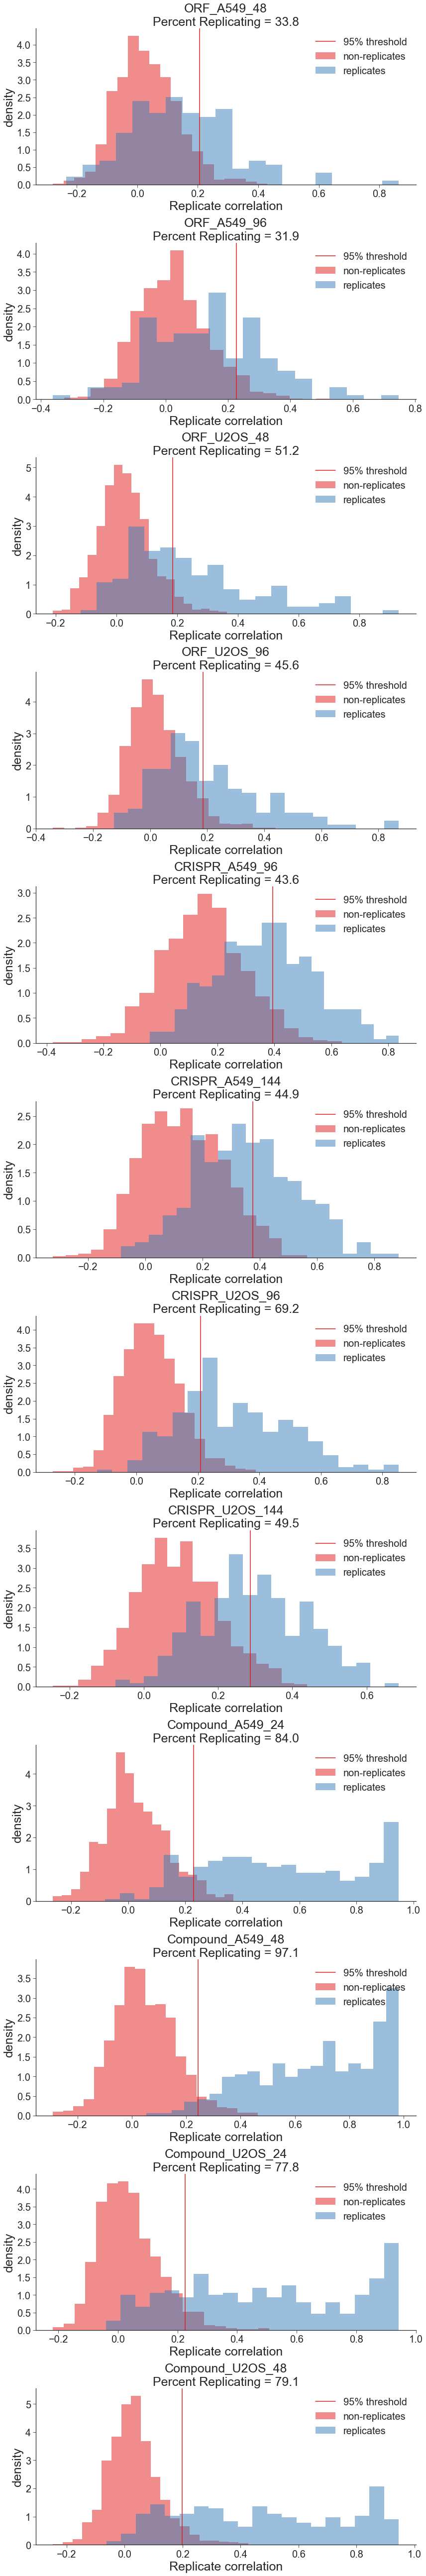

In [5]:
n_experiments = len(corr_replicating_df)

plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(corr_replicating_df.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
    plt.hist(corr_replicating_df.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
    plt.axvline(corr_replicating_df.loc[i,'Value_95'], label='95% threshold')
    plt.legend(fontsize=20)
    plt.title(
        f"{corr_replicating_df.loc[i,'Description']}\n" +
        f"Percent Replicating = {corr_replicating_df.loc[i,'Percent_Replicating']}",
        fontsize=25
    )
    plt.ylabel("density", fontsize=25)
    plt.xlabel("Replicate correlation", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()
plt.tight_layout()
plt.savefig('figures/0.percent_replicating.png')

In [6]:
corr_replicating_df['Percent_Replicating'] = corr_replicating_df['Percent_Replicating'].astype(float)

corr_replicating_df.loc[(corr_replicating_df.Modality=='Compound') & (corr_replicating_df.time=='24'), 'time'] = 'short'
corr_replicating_df.loc[(corr_replicating_df.Modality=='Compound') & (corr_replicating_df.time=='48'), 'time'] = 'long'
corr_replicating_df.loc[(corr_replicating_df.Modality=='CRISPR') & (corr_replicating_df.time=='96'), 'time'] = 'short'
corr_replicating_df.loc[(corr_replicating_df.Modality=='CRISPR') & (corr_replicating_df.time=='144'), 'time'] = 'long'
corr_replicating_df.loc[(corr_replicating_df.Modality=='ORF') & (corr_replicating_df.time=='48'), 'time'] = 'short'
corr_replicating_df.loc[(corr_replicating_df.Modality=='ORF') & (corr_replicating_df.time=='96'), 'time'] = 'long'

plot_corr_replicating_df = (
    corr_replicating_df.rename(columns={'Modality':'Perturbation'})
    .drop(columns=['Null_Replicating','Value_95','Replicating'])
)

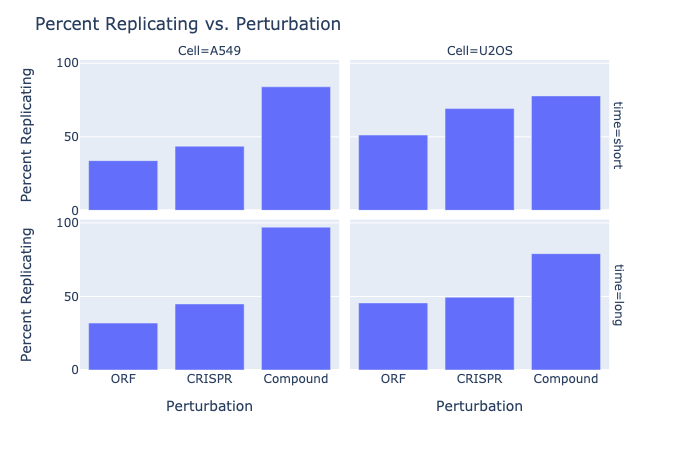

In [7]:
fig = px.bar(data_frame=plot_corr_replicating_df,
             x='Perturbation',
             y='Percent_Replicating',
             facet_row='time',
             facet_col='Cell')
fig.update_layout(title='Percent Replicating vs. Perturbation',
                  yaxis=dict(title='Percent Replicating'),
                  yaxis3=dict(title='Percent Replicating'))
fig.show("png")
fig.write_image(f'figures/0.percent_replicating_facet.png', width=640, height=480, scale=2)

In [8]:
print(plot_corr_replicating_df[['Description','Perturbation','time', 'Cell' ,'Percent_Replicating']].to_markdown(index=False))

| Description      | Perturbation   | time   | Cell   |   Percent_Replicating |
|:-----------------|:---------------|:-------|:-------|----------------------:|
| ORF_A549_48      | ORF            | short  | A549   |                  33.8 |
| ORF_A549_96      | ORF            | long   | A549   |                  31.9 |
| ORF_U2OS_48      | ORF            | short  | U2OS   |                  51.2 |
| ORF_U2OS_96      | ORF            | long   | U2OS   |                  45.6 |
| CRISPR_A549_96   | CRISPR         | short  | A549   |                  43.6 |
| CRISPR_A549_144  | CRISPR         | long   | A549   |                  44.9 |
| CRISPR_U2OS_96   | CRISPR         | short  | U2OS   |                  69.2 |
| CRISPR_U2OS_144  | CRISPR         | long   | U2OS   |                  49.5 |
| Compound_A549_24 | Compound       | short  | A549   |                  84   |
| Compound_A549_48 | Compound       | long   | A549   |                  97.1 |
| Compound_U2OS_24 | Compound       | sh